<a href="https://colab.research.google.com/github/MahmoodAbdali79/Telecom-Churn/blob/main/Telecom_EDA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import scipy.stats as st
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor



import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [36]:
# inspire https://github.com/ShivaliPatel/Data-science-projects/tree/master/Telco_customer_churn

In [37]:
df = pd.read_csv('drive/MyDrive/Data/Telco-Customer-Churn.csv')

In [38]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Manipulation and Handeling Missing Value


- `CustomerID` does not have valuable information.
- `TotalCharges` is object types and has some NA value. I decide fill them by mode for now.   

- value of 0 for tenure is not valid. so I drop them.
- Also I created a feature column for missing value. but related rows also doesnt have valid tenure and droped.
- I turn value of `SeniorCitizen` to categorical value for now.
- At the end I check if there is one value in a any column or not

In [40]:
def preprocess(df):
  # drop Customer ID
  df.drop(['customerID'], axis=1, inplace=True)

  # turn into numerical and fill NA value
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
  df['TotalCharges_missing'] = df['TotalCharges'].isnull().astype(int)

  imputation_value = df['TotalCharges'].mode()[0] # for considering mode
  # imputation_value = df['TotalCharges'].mean() # for considering mean
  # imputation_value = df['TotalCharges'].median() # for considering median
  df['TotalCharges'] = df['TotalCharges'].fillna(imputation_value)

  # drop rows with tenure of 0
  df.drop(labels=df[df['tenure']==0].index, axis=0, inplace=True)

  # map SeniorCitizen
  df['SeniorCitizen'] = df['SeniorCitizen'].map({0:"No", 1:"Yes"})

  for col in df.columns:
    if len(df[col].unique()) < 2:
      df.drop(col, axis=1, inplace=True)
  return df

In [41]:
df = preprocess(df)

# EDA


## **First sense and Assumption**
- just 25% of our customers churned in this data set. So there is an imbalance in target value which should be addressed later.
- `Gender` does not play an important role.
- Customers who don't have a partner or aren't dependent, churn more.
- Maybe people who use `PhoneServie` churn less than people who don't use it.
- Customers who churn are likely not to have DSL or use internet service
- Customers who churn are likely not to use Online security service
- Customers who churn are likely not to use Online Backup
- Customers who churn are likely not to use Device protection and Tech support
- Customers who churn are likely to use less streaming TV and streaming Movies.
- Customers who churn have monthly-to-monthly contracts (i.e loyal customers churn less than others)
- Customers who churn mostly don't use mailed checks, bank transfer, credit card
- A small part of Senior citizens like to churn
<hr>


## **Correlation**:  
most correlated features with `Churn` respectively are:
- `Contract`           -0.39
- `tenure`             -0.35
- `OnlineSecurity`     -0.28
- `TechSupport`        -0.28
- `TotalCharges`       -0.19
- `OnlineBackup`       -0.19
- `PaperlessBilling`    0.19
- `MonthlyCharges`      0.19

**multicollinearity**: There is a multicollinearity between some featues but I dont addres this for now.


## Visualization

### Target Distribution

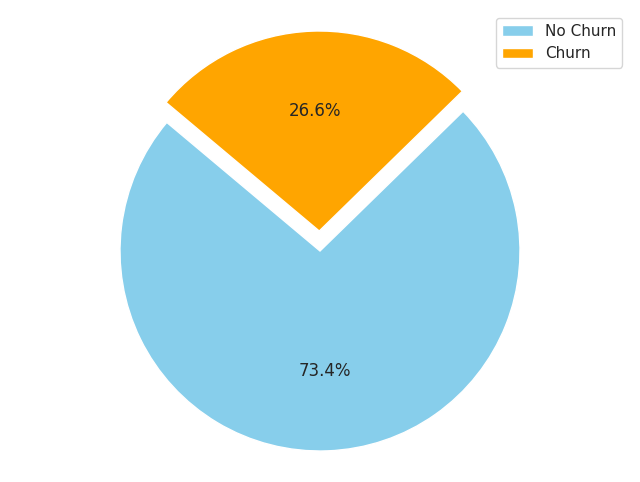

In [42]:
plt.figure(figsize=(8, 6))
colors = ['skyblue', 'orange']
sizes = df['Churn'].value_counts(normalize=True)
explode = (0, 0.1)  # explode the second slice (Churned)
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=140)
plt.legend(['No Churn', 'Churn'], loc='upper right')
plt.axis('equal')
plt.show()

as we can see. the target value is not balanced and this can effect on out machin learning modle.

### Explore Categorical Variable

In [43]:
var = "gender"
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [44]:
var = 'Partner'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [45]:
var = 'Dependents'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [46]:
var = 'PhoneService'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [47]:
var = 'MultipleLines'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [48]:
var = 'InternetService'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [49]:
var = 'OnlineSecurity'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [50]:
var = 'OnlineBackup'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [51]:
var = 'DeviceProtection'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [52]:
var = 'TechSupport'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [53]:
var = 'StreamingTV'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [54]:
var = 'StreamingMovies'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [55]:
var = 'Contract'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [56]:
var = 'PaymentMethod'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

In [57]:
var = 'SeniorCitizen'
fig = px.histogram(df, x="Churn", color=var, barmode="group")
fig.update_layout(width=600, height=400, bargap=0.1)
fig.show()

### Explore Numerical Variable and Identify Outlier

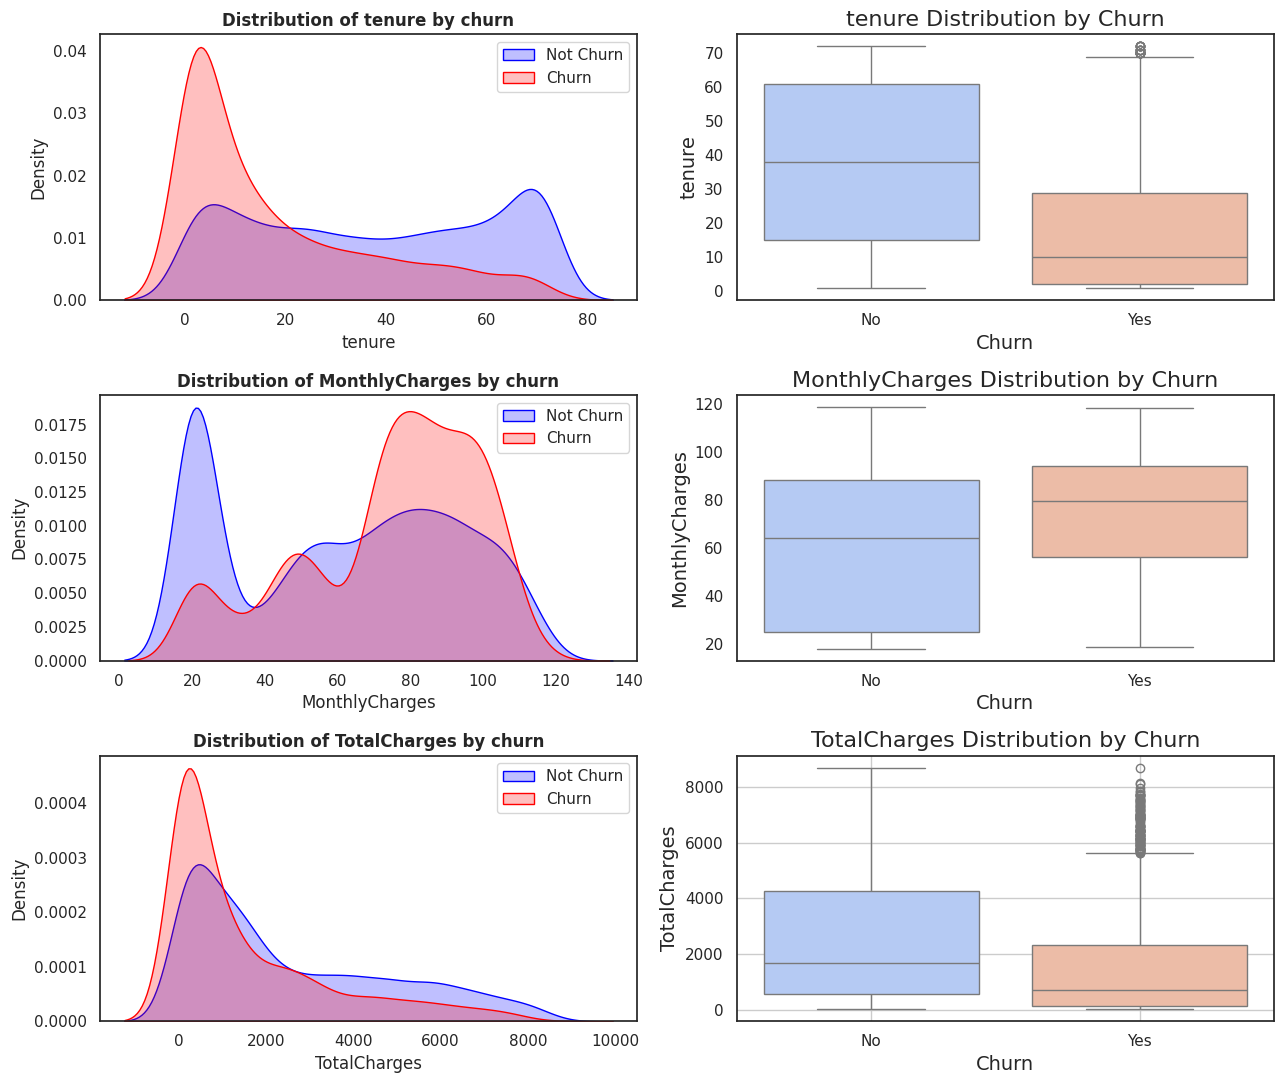

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(13, 11))
numerical_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

for ax, col in zip(axes, numerical_vars):
  sns.kdeplot(df[col][(df["Churn"] == 'No')], color="Blue", fill=True, ax=ax[0])
  sns.kdeplot(df[col][(df["Churn"] == 'Yes')], color="Red", fill= True, ax=ax[0])
  ax[0].legend(["Not Churn","Churn"],loc='upper right')
  ax[0].set_title(f'Distribution of {col} by churn', fontweight="bold")

  sns.boxplot(x='Churn', y=col, data=df, palette='coolwarm', hue='Churn', ax=ax[1])
  ax[1].set_title(f'{col} Distribution by Churn', fontsize=16)
  ax[1].set_xlabel('Churn', fontsize=14)
  ax[1].set_ylabel(col, fontsize=14)
  plt.grid(True)


fig.tight_layout()
plt.show()

### Hypothetis for compairing mean and median.

I wanna check if there is a significant in numerical data based churn / not churn user. To do this I user hypothesis on originala and sample mean data to check out this.


**H0**: Mean of (tenure, MonthlyCharges, TotalCharges) for user two group of people who churn/not churn is equal

**H1**: Mean of (tenure, MonthlyCharges, TotalCharges) for user two group of people who churn/not churn is not equal

**CL**: 0.95

#### By orginal data

In [59]:
# normal test
for var in numerical_vars:
  Churn = df[df['Churn']=='Yes'][var]
  Not_Churn = df[df['Churn']=='No'][var]
  print(f'P-value of {var} - churn : {st.normaltest(Churn)[1]:.3f}')
  print(f'P-value of {var} - Not churn : {st.normaltest(Not_Churn)[1]:.3f}')

P-value of tenure - churn : 0.000
P-value of tenure - Not churn : 0.000
P-value of MonthlyCharges - churn : 0.000
P-value of MonthlyCharges - Not churn : 0.000
P-value of TotalCharges - churn : 0.000
P-value of TotalCharges - Not churn : 0.000


Orifinal data is not normal. So I sue Mann–Whitney U test to check this hypothesis.

In [60]:
Churn = df[df['Churn']=='Yes']
Not_Churn = df[df['Churn']=='No']

for var in numerical_vars:
  statistics, p_value = st.mannwhitneyu(Churn[var], Not_Churn[var], alternative ='less')
  print(f'Mann-Whitney U-test for {var}:')
  print(f'  Test Statistics: {statistics:.3f}')
  print(f'  P-value: {p_value:.5f}')

  if p_value <0.05:
    print(f'  There is significant difference in {var} between churned and not churned customer')
  else:
    print(f'  There is not significant difference in {var} between churned and not churned customer')
  print()

Mann-Whitney U-test for tenure:
  Test Statistics: 2494979.000
  P-value: 0.00000
  There is significant difference in tenure between churned and not churned customer

Mann-Whitney U-test for MonthlyCharges:
  Test Statistics: 5986148.500
  P-value: 1.00000
  There is not significant difference in MonthlyCharges between churned and not churned customer

Mann-Whitney U-test for TotalCharges:
  Test Statistics: 3360665.000
  P-value: 0.00000
  There is significant difference in TotalCharges between churned and not churned customer



#### By normall sample data

In othrt way I can create a normal ditributed data by useing sample mean

In [61]:
def TurnIntolist(x):
  if isinstance(x, list):
    pass
  else:
    x = [x]
  return x

def significant_test(numerical_vars, df):
  numerical_vars = TurnIntolist(numerical_vars)
  # Define the sample size and number of samples
  sample_size = 100  # Adjust as needed
  num_samples = 1000  # Adjust as needed
  np.random.seed(0)
  NoT_churn_sample_data = pd.DataFrame(columns=numerical_vars)
  Churn_sample_data = pd.DataFrame(columns=numerical_vars)

  for var in numerical_vars:
    # Generate the non-normally distributed population data
    NoT_churn_data = df[df['Churn']=='No'][var]
    Churn_data = df[df['Churn']=='Yes'][var]

    # Create an array to store the sample means
    NoT_churns_ample_means = np.zeros(num_samples)
    Churn_sample_means = np.zeros(num_samples)

    # Generate samples and calculate sample means
    for i in range(num_samples):
        NoT_churn_sample = np.random.choice(NoT_churn_data, size=sample_size, replace=True)
        NoT_churns_ample_means[i] = np.mean(NoT_churn_sample)

        churn_sample = np.random.choice(Churn_data, size=sample_size, replace=True)
        Churn_sample_means[i] = np.mean(churn_sample)

    NoT_churn_sample_data[var] = NoT_churns_ample_means
    Churn_sample_data[var] = Churn_sample_means

    # Perform a normality test on the sample means
    NoT_churn_normality_test_P = st.normaltest(NoT_churn_sample_data[var])[1]
    churn_normality_test_P = st.normaltest(Churn_sample_data[var])[1]
    print(f'Normality Test Result for {var}:')
    print(f'Not Churn Normality P-value = {NoT_churn_normality_test_P:.3f}')
    print(f'Churn Normality P-value = {churn_normality_test_P:.3f}')

    if NoT_churn_normality_test_P > 0.05 and churn_normality_test_P > 0.005:

      t_statistic, p_value = st.ttest_ind(NoT_churn_sample_data[var], Churn_sample_data[var])

      # Print the test result
      print(f'Two-sample t-test for {var}')
      print("T-statistic:", t_statistic)
      print("P-value:", p_value)

      # Check the significance level (usually 0.05)
      alpha = 0.05
      if p_value < alpha:
          print(f"The {var} are significantly different between churn / not churn")
      else:
          print(f"There is no significant difference in {var} between churn / not churn.")
    else:
      print('sample datas are not normal, rerun the function')
    print('-----------------------------')


In [62]:
significant_test(['tenure', 'MonthlyCharges', 'TotalCharges'], df)

Normality Test Result for tenure:
Not Churn Normality P-value = 0.830
Churn Normality P-value = 0.044
Two-sample t-test for tenure
T-statistic: 203.87906466696862
P-value: 0.0
The tenure are significantly different between churn / not churn
-----------------------------
Normality Test Result for MonthlyCharges:
Not Churn Normality P-value = 0.389
Churn Normality P-value = 0.240
Two-sample t-test for MonthlyCharges
T-statistic: -104.5109707962799
P-value: 0.0
The MonthlyCharges are significantly different between churn / not churn
-----------------------------
Normality Test Result for TotalCharges:
Not Churn Normality P-value = 0.334
Churn Normality P-value = 0.364
Two-sample t-test for TotalCharges
T-statistic: 108.12018316242401
P-value: 0.0
The TotalCharges are significantly different between churn / not churn
-----------------------------


## Correlation Analysis

In [63]:
#Create a label encoder object
le = LabelEncoder()
# Label Encoding will be used for columns with 2 or less unique
LDF = df.copy()
lablaed = []

for col in df.columns:
    if df[col].dtype == 'object':
      le.fit(df[col])
      LDF[col] = le.transform(df[col])
      lablaed.append(col)

# filtter same correlation
correlation = LDF.corrwith(LDF.Churn)
correlation = correlation[correlation!=1].sort_values()

# plot correlation
fig = px.bar(correlation, x=correlation.index, y = correlation.values)
fig.show()

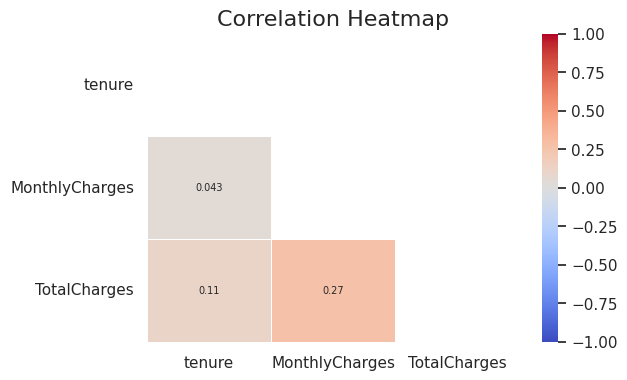

In [64]:
sns.set(style="white")
plt.figure(figsize=(6, 4))

# selecting numerical variables
numerical_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Calculate correlation matrix
corr = LDF[numerical_vars].apply(lambda x: pd.factorize(x)[0]).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with adjusted font size
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns,
                 annot=True, annot_kws={"size": 7}, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap', fontsize=16)

plt.show()

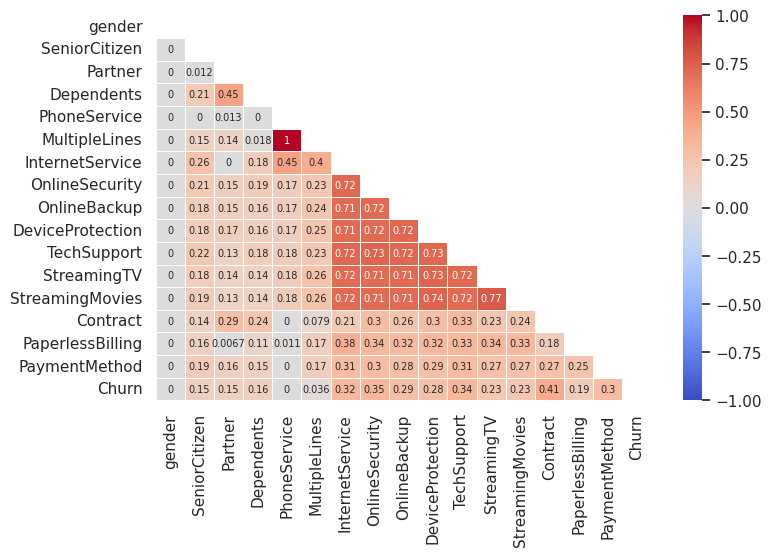

In [65]:
# Example data (replace with your data)
cat_data = LDF.drop(numerical_vars, axis=1)

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = st.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramér's V for each pair of variables
corr_matrix = pd.DataFrame(index=cat_data.columns, columns=cat_data.columns, dtype=float)
for i in range(len(cat_data.columns)):
    for j in range(len(cat_data.columns)):
        corr_matrix.iloc[i, j] = cramers_v(cat_data.iloc[:, i], cat_data.iloc[:, j])


sns.set(style="white")
plt.figure(figsize=(8, 5))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

ax = sns.heatmap(corr_matrix, mask=mask, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,
                 annot=True, annot_kws={"size": 7}, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Some features has multicollinearity.To prove this I calculate VIF.  


In [66]:
vif = pd.DataFrame()
vif["variables"] = LDF.columns
vif["VIF"] = [variance_inflation_factor(LDF.values, i) for i in range(LDF.shape[1])]

vif.sort_values(by='VIF')

,variables,VIF
1,SeniorCitizen,1.373354
19,Churn,1.861969
0,gender,1.954856
3,Dependents,1.957986
8,OnlineSecurity,2.257841
11,TechSupport,2.392227
9,OnlineBackup,2.459222
10,DeviceProtection,2.631343
6,MultipleLines,2.761146
2,Partner,2.819317


How can address this issue?
- **Feature Selection**: Remove one of the highly correlated variables
- **Dimensionality Reduction**: Transform the correlated predictors into a smaller set of uncorrelated variables useing PCA.
- **Regularization**: Using ridge regression to add a penalty term to the regression coefficients, which reduces their magnitude and helps mitigate multicollinearity.
- **Variable Transformation**: Combine highly correlated predictors
- **Cross-validation**: Evaluate models using cross-validation techniques to assess their performance in handling multicollinearity and to prevent overfitting.

# Save data

In [67]:
df.to_csv('drive/MyDrive/Data/Telco-Customer-Churn_V1.csv')